# Exercise 1 Solutions

*Portions of these solutions are based on student-submitted code.*

## Question One

This exercise is based on the "Benchmark Bond Trade Price Challenge" which
was conducted on the web site Kaggle.com.
You can see the full details of this challenge at
[http://www.kaggle.com/c/benchmark-bond-trade-price-challenge](http://www.kaggle.com/c/benchmark-bond-trade-price-challenge),
but you may have to register (it is free).
This is reproduced from the "Background" section:

<blockquote>
As far as price transparency is concerned, there has historically been a huge gap between the amount of reference information available to those trading equities versus those trading corporate bonds.  Stock exchanges report trades, bids and offers at all times.  Free access is available online with a 15 minute delay while traders who demand more information can pay for ultra efficient real time data and information about size of current bids and offers. By contrast, bond trades are required to be reported within 15 minutes and only those who pay for the TRACE feed can access this information.  No quotes are publicly available and the best way to get a quote is to solicit multiple brokers and wait for a reply.  Alternatively there are data companies that provide end of day prices, published after the market has closed and with no guarantee that the specific information sought will be included.  Accurate bond pricing is also hindered by lack of liquidity.  Only a fraction of TRACE eligible bonds trade on a given day, so the most recent trade price is often multiple days old.  Pricing bonds based on other more liquid bonds that have similar features is common, but again limited by the presence of such bonds.

Benchmark Solutions is the first provider of realtime corporate bond prices. Every 10 seconds we provide accurate prices that incorporate interest rate data, trades or quotes of the bond in question, trades or quotes of other bonds or CDS of the issuer of the bond in question as well as other input sources.  Pricing bonds accurately requires an exacting knowledge of payment schedules, trading calenders and reference data for each bond.  This, as well as synthesizing all of the bonds and CDS quotes and trades of a given issuer into implied hazard and funding curves, is something that we feel is beyond the scope of this challenge.  Rather, we provide you with a reference price which is an intermediate result of our calculations and is labeled 'curve\_based\_price'  in the dataset. Thus the competition focuses on trading dynamics and microstructure of individual bonds, rather than all bonds from a given issuer.
</blockquote>

We created a reduced data set in order to make this challenge
something we could manage during this exercise. This data set is available on CANVAS

We will fit regression models which attempt to model `trade_price'

## Setup

This initial portion of code reads in the data set.

In [1]:
import pandas as pd
data = pd.read_csv("bonddata.txt")

These are the first few rows of the data set.

In [2]:
data.head()

,id,bond_id,trade_price,weight,current_coupon,time_to_maturity,is_callable,reporting_delay,trade_size,trade_type,...,received_time_diff_last9,trade_price_last9,trade_size_last9,trade_type_last9,curve_based_price_last9,received_time_diff_last10,trade_price_last10,trade_size_last10,trade_type_last10,curve_based_price_last10
0,10,1,126.268,7.616851,5.950,25.940349,0,12.540,150000.0,3,...,2862729,128.596,120000.0,2,127.561201,3621492,129.089,200000.0,2,129.435587
1,38,2,101.009,0.018373,3.550,0.326392,0,9.327,450000.0,3,...,532644,101.086,500000.0,2,101.103180,538510,101.070,25000.0,2,101.102243
2,336,3,108.144,3.537380,4.200,2.340601,0,0.102,160000.0,4,...,96293,107.917,400000.0,2,107.874965,96293,107.917,400000.0,4,107.874965
3,781,4,116.953,0.402523,4.875,7.367653,0,52.093,10000.0,4,...,92559,115.924,10000.0,2,116.160420,97177,116.458,2000.0,3,116.342802
4,1172,14,133.210,0.210685,10.750,4.159301,0,13.722,25000.0,4,...,6400208,127.500,25000.0,2,131.066998,6400208,127.500,25000.0,4,131.066998


The size of the data set.

In [3]:
data.shape

(1620, 61)

These next commands remove some variables which are not useful predictors, and define some variables to be categorical.

In [4]:
data = data.drop(['id', 'bond_id'], axis=1)

In [5]:
data['is_callable'] = data['is_callable'].astype('category').cat.as_unordered()
data['trade_type'] = data['trade_type'].astype('category').cat.as_unordered()
data['trade_type_last1'] = data['trade_type_last1'].astype('category').cat.as_unordered()
data['trade_type_last2'] = data['trade_type_last2'].astype('category').cat.as_unordered()
data['trade_type_last3'] = data['trade_type_last3'].astype('category').cat.as_unordered()
data['trade_type_last4'] = data['trade_type_last4'].astype('category').cat.as_unordered()
data['trade_type_last5'] = data['trade_type_last5'].astype('category').cat.as_unordered()
data['trade_type_last6'] = data['trade_type_last6'].astype('category').cat.as_unordered()
data['trade_type_last7'] = data['trade_type_last7'].astype('category').cat.as_unordered()
data['trade_type_last8'] = data['trade_type_last8'].astype('category').cat.as_unordered()
data['trade_type_last9'] = data['trade_type_last9'].astype('category').cat.as_unordered()
data['trade_type_last10'] = data['trade_type_last10'].astype('category').cat.as_unordered()

## Transforming Predictors

Some of the non-categorical predictors have distributions which are highly skewed. For example, take a look at the  histogram below.

<AxesSubplot:>

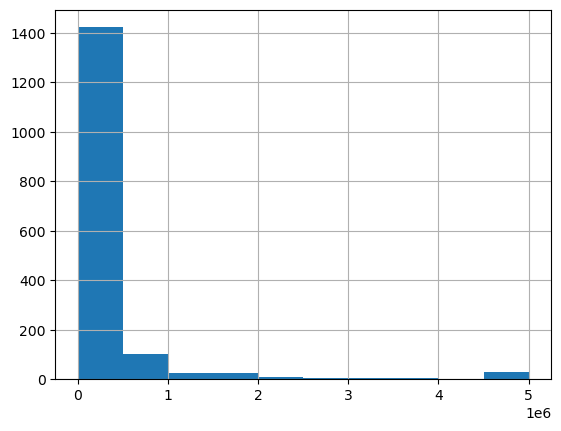

In [6]:
data['trade_size_last1'].hist()

For predictors with such a distribution, it can be a very good idea to transform them prior to fitting the model. For strictly positive variables, a log transform is common, while for nonnegative variables a square root transform has a similar effect. For this reason, the following transformations are applied.

In [7]:
import numpy as np
data['time_to_maturity_lt'] = np.log(data['time_to_maturity'])
data['trade_size_lt'] = np.log(data['trade_size'])

data['trade_size_last1_lt'] = np.log(data['trade_size_last1'])
data['trade_size_last2_lt'] = np.log(data['trade_size_last2'])
data['trade_size_last3_lt'] = np.log(data['trade_size_last3'])
data['trade_size_last4_lt'] = np.log(data['trade_size_last4'])
data['trade_size_last5_lt'] = np.log(data['trade_size_last5'])
data['trade_size_last6_lt'] = np.log(data['trade_size_last6'])
data['trade_size_last7_lt'] = np.log(data['trade_size_last7'])
data['trade_size_last8_lt'] = np.log(data['trade_size_last8'])
data['trade_size_last9_lt'] = np.log(data['trade_size_last9'])
data['trade_size_last10_lt'] = np.log(data['trade_size_last10'])

data['received_time_diff_last1_st'] = np.sqrt(data['received_time_diff_last1'])
data['received_time_diff_last2_st'] = np.sqrt(data['received_time_diff_last2'])
data['received_time_diff_last3_st'] = np.sqrt(data['received_time_diff_last3'])
data['received_time_diff_last4_st'] = np.sqrt(data['received_time_diff_last4'])
data['received_time_diff_last5_st'] = np.sqrt(data['received_time_diff_last5'])
data['received_time_diff_last6_st'] = np.sqrt(data['received_time_diff_last6'])
data['received_time_diff_last7_st'] = np.sqrt(data['received_time_diff_last7'])
data['received_time_diff_last8_st'] = np.sqrt(data['received_time_diff_last8'])
data['received_time_diff_last9_st'] = np.sqrt(data['received_time_diff_last9'])
data['received_time_diff_last10_st'] = np.sqrt(data['received_time_diff_last10'])

In [8]:
datatransformed = data.drop(['received_time_diff_last1','received_time_diff_last2','received_time_diff_last3',
                 'received_time_diff_last4','received_time_diff_last5','received_time_diff_last6',
                 'received_time_diff_last7','received_time_diff_last8','received_time_diff_last9',
                 'received_time_diff_last10','trade_size_last1','trade_size_last2','trade_size_last3',
                 'trade_size_last4','trade_size_last5','trade_size_last6','trade_size_last7',
                 'trade_size_last8','trade_size_last9','trade_size_last10','time_to_maturity',
                'trade_size'], axis=1)

## Constructing the Design Matrix

This next command will appropriate construct the design matrix for this model. The first version `designmatrix` does not contain the column of ones, while the second version `desginmatrix_withones` does include that column of ones.

In [9]:
designmatrix = pd.get_dummies(datatransformed.drop(['trade_price'],axis=1),drop_first=True)

In [10]:
import statsmodels.api as sm

designmatrix_withones = sm.add_constant(designmatrix) 

## Exercises

Now, do each of the following:

1. Fit the model using including all of the predictors (i.e., using the entire design matrix you just constructed), via `sm.OLS`. Remember that `trade_price` is the response. Show the `summary` output.

2. Construct the plot of residuals versus fitted values for the model fit in Question 1. Comment on the quality of the fit.

3. Construct the normal probability plot of the residuals. What does this plot tell us?

4. Implement a stepwise variable selection procedure using AIC to find a simpler model. Report on the resulting model.

5. Repeat the above, but use PRESS instead of AIC. How does the resulting model change? 

## Part 1

We fit the model as follows:

In [11]:
fullmod = sm.OLS(endog=data['trade_price'], exog=designmatrix_withones).fit()
fullmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            trade_price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1128.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:25:26   Log-Likelihood:                -3065.8
No. Observations:                1620   AIC:                             6272.
Df Residuals:                    1550   BIC:                             6649.
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.6567      0.664      0.988      0.323      -0.647       1.960
weight                          -8.3318     13.550     -0.615      0.539     -34.911      18.247
current_coupon                   0.0252      0.030      0.838      0.402      -0.034       0.084
reporting_delay              -1.618e-06   1.24e-06     -1.304      0.192   -4.05e-06    8.16e-07
curve_based_price                0.3916      0.040      9.693      0.000       0.312       0.471
trade_price_last1                0.4094      0.036     11.266      0.000       0.338       0.481
curve_based_price_last1         -0.0295      0.068     -0.435      0.663      -0.162       0.103
trade_price_last2                0.0330      0.040      0.831      0.406      -0.045       0.111
curve_based_price_last2         -0.0682      0.071     -0.964      0.335      -0.207       0.071
trade_price_last3                0.0485      0.037      1.304      0.192      -0.024       0.121
curve_based_price_last3         -0.1338      0.072     -1.857      0.063      -0.275       0.008
trade_price_last4                0.0877      0.035      2.502      0.012       0.019       0.156
curve_based_price_last4          0.2051      0.076      2.709      0.007       0.057       0.354
trade_price_last5                0.0432      0.037      1.180      0.238      -0.029       0.115
curve_based_price_last5         -0.2475      0.074     -3.360      0.001      -0.392      -0.103
trade_price_last6               -0.0383      0.036     -1.056      0.291      -0.109       0.033
curve_based_price_last6          0.1129      0.072      1.559      0.119      -0.029       0.255
trade_price_last7                0.1130      0.036      3.126      0.002       0.042       0.184
curve_based_price_last7         -0.0657      0.070     -0.938      0.349      -0.203       0.072
trade_price_last8                0.0140      0.033      0.421      0.674      -0.051       0.079
curve_based_price_last8         -0.0381      0.069     -0.550      0.582      -0.174       0.098
trade_price_last9                0.0638      0.034      1.865      0.062      -0.003       0.131
curve_based_price_last9         -0.0007      0.065     -0.010      0.992      -0.128       0.127
trade_price_last10               0.0332      0.030      1.099      0.272      -0.026       0.092
curve_based_price_last10         0.0546      0.053      1.020      0.308      -0.050       0.160
time_to_maturity_lt             -0.0019      0.045     -0.043      0.966      -0.089       0.085
trade_size_lt                    0.1361      0.026      5.205      0.000       0.085       0.187
trade_size_last1_lt             -0.0807      0.031     -2.600      0.009      -0.142      -0.020
trade_size_last2_lt              0.0253      0.034      0.743      0.458    

This model has 70 $\beta$ parameters, including the intercept term, relative to a sample size of 1620. Given this, it is probably not too surprising that $R^2$ comes out to be large. There is some reason to be concerned that we are overfitting to the sample in this case.

Also, at this point, we do not know anything about the quality of the fit of this model. Having a large $R^2$ does not say anything about the quality of the fit.

## Parts 2 and 3

The following commands will create the desired residual plots.

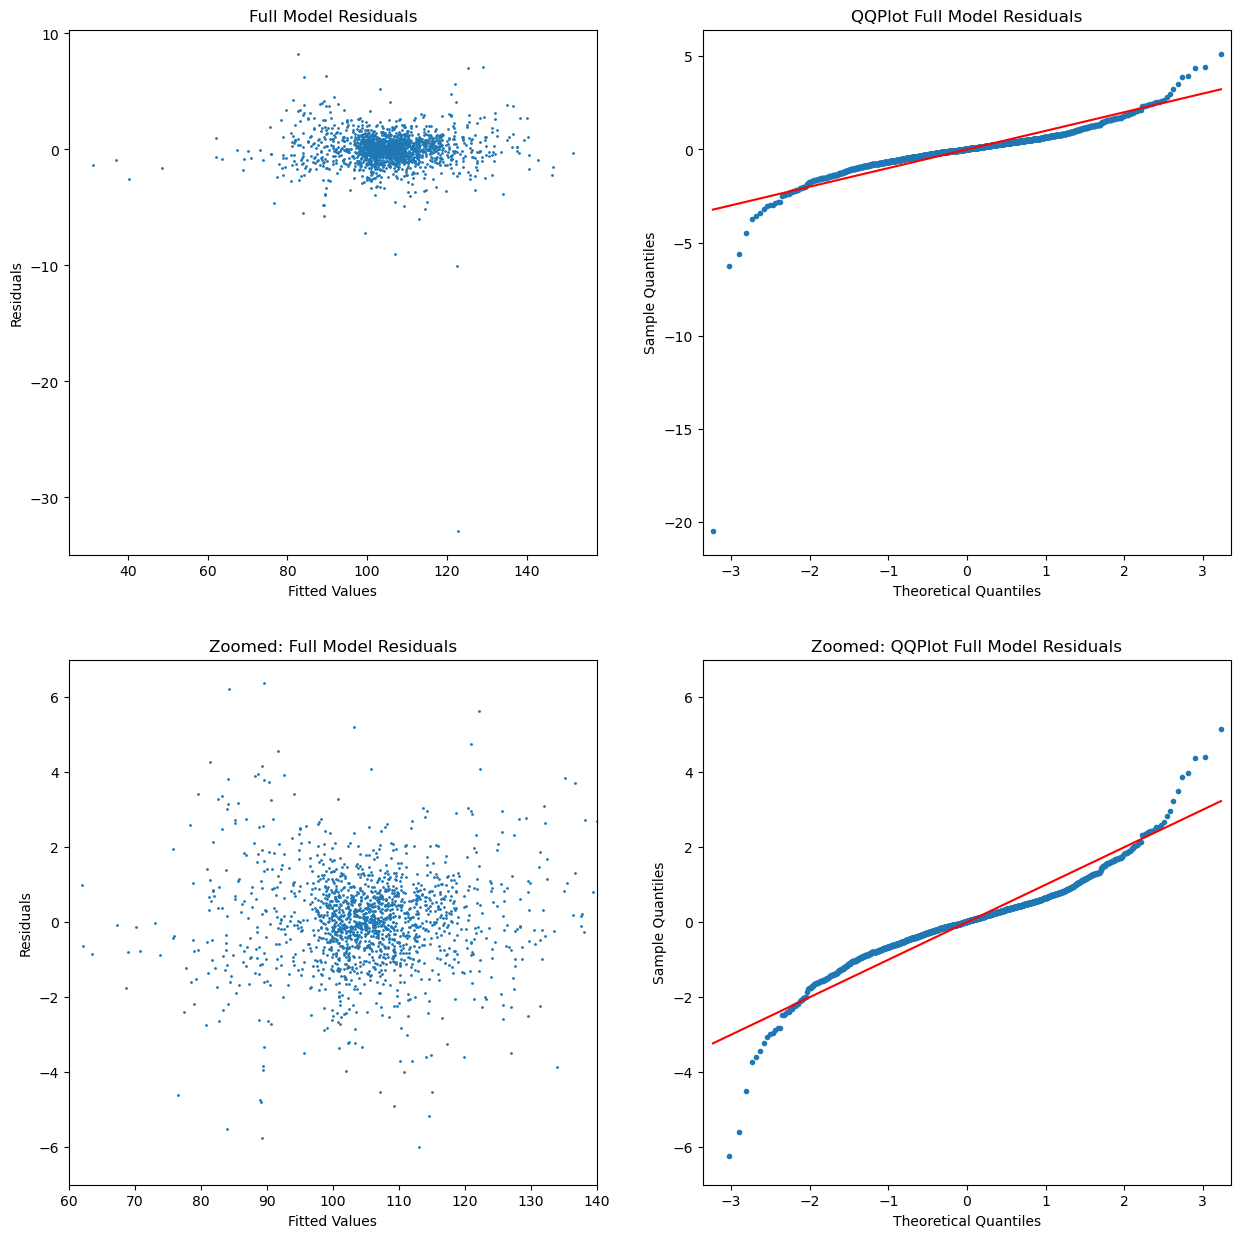

In [12]:
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import scipy.stats.distributions as spdists

fig, ax = plt.subplots(2,2, figsize=[15,15])
ax[0,0].scatter(fullmod.fittedvalues, fullmod.resid, s = 1.0)
ax[0,0].set(xlabel='Fitted Values', ylabel='Residuals', title='Full Model Residuals')

ax[1,0].scatter(fullmod.fittedvalues, fullmod.resid, s = 1.0)
ax[1,0].set(xlabel='Fitted Values', ylabel='Residuals', title='Zoomed: Full Model Residuals',
           ylim=[-7,7], xlim=[60,140])

sm.qqplot(fullmod.resid, line='s', dist=spdists.norm, marker='.', ax=ax[0,1], fit=True)
ax[0,1].set(title = 'QQPlot Full Model Residuals')

sm.qqplot(fullmod.resid, line='s', dist=spdists.norm, marker='.', ax=ax[1,1], fit=True)
ax[1,1].set(title = 'Zoomed: QQPlot Full Model Residuals', ylim=[-7,7])
plt.show()

The two top graphs show the plot of residuals versus fitted values, and the normal probability plot of the residuals. In each case, it is clear that there is one observation that appears to be quite extreme relative to the others. This outlier could skew the interpretation of the plot, so versions are created that focus only on the region where the remaining data lie. Those are shown on the bottom.

The plot of residuals versus fitted values does not show any clear indication of lack of fit of the model. Nothing in this plot, beyond the presence of the outlier, creates concern.

The normal probability plot indicates that the errors have heavier tails than what the normal distribution would imply.

## Part 4


Here we implement a stepwise approach to variable selection using AIC as the criterion.

In [13]:
import itertools
from tqdm import notebook, trange
from IPython.display import display, Math

features_chosen_AIC = []
remaining_features = list(designmatrix.columns.values)
best_AIC = np.inf

for i in trange(1, len(designmatrix.columns)+1):
    add_feature = False
    
    for combo in itertools.combinations(remaining_features, 1):
        designmatrix_withones = sm.add_constant(
        designmatrix[list(combo) + features_chosen_AIC])
        model = sm.OLS(endog=data['trade_price'], 
                       exog=designmatrix_withones).fit()
        this_AIC = model.aic
        
        if this_AIC < best_AIC:
            add_feature = True
            best_AIC = this_AIC
            best_feature = combo[0]
    
    if add_feature:
        features_chosen_AIC.append(best_feature)
        remaining_features.remove(best_feature)

# Optimal Variable Selection
features_chosen_AIC

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:17<00:00,  3.86it/s]


['trade_price_last1',
 'curve_based_price',
 'trade_type_3',
 'trade_price_last7',
 'trade_type_4',
 'trade_price_last10',
 'trade_price_last4',
 'curve_based_price_last5',
 'trade_size_lt',
 'trade_type_last1_3',
 'trade_type_last4_3',
 'trade_size_last1_lt',
 'trade_type_last1_4',
 'trade_type_last4_4',
 'trade_type_last5_3',
 'trade_price_last9',
 'curve_based_price_last2',
 'curve_based_price_last4',
 'trade_size_last4_lt',
 'is_callable_1',
 'curve_based_price_last3',
 'trade_price_last3',
 'received_time_diff_last10_st',
 'received_time_diff_last8_st']

The new model has 25 $\beta$ parameters (including the intercept term).

In [14]:
X_with_ones_AIC = sm.add_constant(designmatrix.loc[:,features_chosen_AIC])

SW_AIC_mod = sm.OLS(endog=data['trade_price'], 
                      exog=X_with_ones_AIC).fit()
SW_AIC_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            trade_price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     3288.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:25:45   Log-Likelihood:                -3077.9
No. Observations:                1620   AIC:                             6206.
Df Residuals:                    1595   BIC:                             6341.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.7060      0.552      1.279      0.201      -0.376       1.788
trade_price_last1                0.4329      0.027     15.866      0.000       0.379       0.486
curve_based_price                0.3762      0.033     11.329      0.000       0.311       0.441
trade_type_3                     1.6066      0.109     14.695      0.000       1.392       1.821
trade_price_last7                0.1111      0.023      4.788      0.000       0.066       0.157
trade_type_4                     0.8977      0.101      8.930      0.000       0.701       1.095
trade_price_last10               0.0505      0.026      1.961      0.050   -9.32e-06       0.101
trade_price_last4                0.1061      0.030      3.505      0.000       0.047       0.165
curve_based_price_last5         -0.1917      0.050     -3.837      0.000      -0.290      -0.094
trade_size_lt                    0.1374      0.025      5.444      0.000       0.088       0.187
trade_type_last1_3              -0.4647      0.115     -4.043      0.000      -0.690      -0.239
trade_type_last4_3              -0.4197      0.121     -3.457      0.001      -0.658      -0.182
trade_size_last1_lt             -0.0744      0.025     -2.928      0.003      -0.124      -0.025
trade_type_last1_4              -0.2487      0.106     -2.345      0.019      -0.457      -0.041
trade_type_last4_4              -0.2115      0.105     -2.022      0.043      -0.417      -0.006
trade_type_last5_3              -0.1603      0.088     -1.827      0.068      -0.332       0.012
trade_price_last9                0.0582      0.027      2.136      0.033       0.005       0.112
curve_based_price_last2         -0.0698      0.052     -1.340      0.180      -0.172       0.032
curve_based_price_last4          0.2085      0.074      2.823      0.005       0.064       0.353
trade_size_last4_lt             -0.0407      0.024     -1.702      0.089      -0.088       0.006
is_callable_1                    0.2049      0.119      1.716      0.086      -0.029       0.439
curve_based_price_last3         -0.1422      0.069     -2.052      0.040      -0.278      -0.006
trade_price_last3                0.0491      0.030      1.619      0.106      -0.010       0.109
received_time_diff_last10_st    -0.0004      0.000     -2.048      0.041      -0.001   -1.79e-05
received_time_diff_last8_st      0.0004      0.000      1.700      0.089    -5.7e-05       0.001
==============================================================================
Omnibus:                     1918.670   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           882653.695
Skew:                          -5.481   Prob(JB):                         0.00
Kurtosis:                     116.825   Cond. No.  

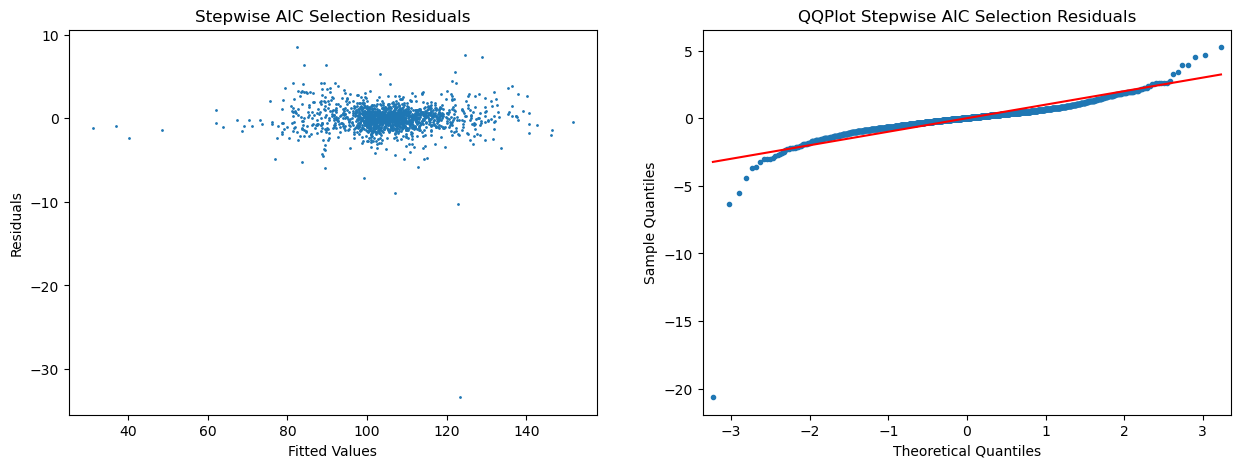

In [15]:
fig, ax = plt.subplots(1,2, figsize=[15,5])
ax[0].scatter(SW_AIC_mod.fittedvalues, SW_AIC_mod.resid, s = 1.0)
ax[0].set(xlabel='Fitted Values', ylabel='Residuals', title='Stepwise AIC Selection Residuals')

sm.qqplot(SW_AIC_mod.resid, line='s', dist=spdists.norm, marker='.', ax=ax[1], fit=True)
ax[1].set(title = 'QQPlot Stepwise AIC Selection Residuals')
plt.show()

By looking at the residual plots, the quality of the fit remains.

## Part 5

Now we repeat the process using leave-one-out cross-validation instead of AIC.

In [16]:
import statsmodels.stats.outliers_influence as outliers_influence

levs = outliers_influence.OLSInfluence(fullmod).hat_matrix_diag

In [17]:
features_chosen_PRESS = []
remaining_features = list(designmatrix.columns.values)
best_PRESS = np.inf

for i in trange(1, len(designmatrix.columns)+1):
    add_feature = False
    
    for combo in itertools.combinations(remaining_features, 1):
        designmatrix_withones = sm.add_constant(
        designmatrix[list(combo) + features_chosen_PRESS])
        model = sm.OLS(endog=data['trade_price'], 
                       exog=designmatrix_withones).fit()
        levs = outliers_influence.OLSInfluence(model).hat_matrix_diag
        this_PRESS = ((model.resid / (1 - levs))**2).sum()
        
        if this_PRESS < best_PRESS:
            add_feature = True
            best_PRESS = this_PRESS
            best_feature = combo[0]
    
    if add_feature:
        features_chosen_PRESS.append(best_feature)
        remaining_features.remove(best_feature)

# Optimal Variable Selection
features_chosen_PRESS

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:23<00:00,  2.97it/s]


['trade_price_last1',
 'curve_based_price',
 'trade_type_3',
 'trade_price_last7',
 'trade_type_4',
 'trade_price_last10',
 'trade_type_last1_3',
 'curve_based_price_last5',
 'trade_price_last4',
 'trade_size_lt',
 'trade_type_last4_3',
 'trade_size_last1_lt',
 'trade_type_last1_4',
 'is_callable_1',
 'trade_type_last4_4',
 'trade_size_last4_lt',
 'trade_type_last7_3',
 'trade_type_last5_3',
 'reporting_delay',
 'trade_price_last9',
 'received_time_diff_last10_st',
 'received_time_diff_last7_st']

Using a PRESS stepwise selection algorithm, the optimal model has 23 $\beta$ parameters, compared to the 70 of the full model.

In [18]:
X_with_ones_PRESS = sm.add_constant(designmatrix.loc[:,features_chosen_PRESS])

SW_PRESS_mod = sm.OLS(endog=data['trade_price'], 
                      exog=X_with_ones_PRESS).fit()
SW_PRESS_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            trade_price   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     3569.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        13:26:08   Log-Likelihood:                -3082.7
No. Observations:                1620   AIC:                             6211.
Df Residuals:                    1597   BIC:                             6335.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.7179      0.553      1.298      0.194      -0.367       1.802
trade_price_last1                0.4272      0.025     16.755      0.000       0.377       0.477
curve_based_price                0.3466      0.028     12.344      0.000       0.292       0.402
trade_type_3                     1.5927      0.109     14.551      0.000       1.378       1.807
trade_price_last7                0.1228      0.025      4.922      0.000       0.074       0.172
trade_type_4                     0.8921      0.101      8.852      0.000       0.694       1.090
trade_price_last10               0.0592      0.026      2.313      0.021       0.009       0.109
trade_type_last1_3              -0.4522      0.114     -3.970      0.000      -0.676      -0.229
curve_based_price_last5         -0.1558      0.029     -5.396      0.000      -0.212      -0.099
trade_price_last4                0.1411      0.025      5.733      0.000       0.093       0.189
trade_size_lt                    0.1379      0.025      5.453      0.000       0.088       0.188
trade_type_last4_3              -0.4568      0.121     -3.784      0.000      -0.694      -0.220
trade_size_last1_lt             -0.0708      0.025     -2.779      0.006      -0.121      -0.021
trade_type_last1_4              -0.2401      0.106     -2.262      0.024      -0.448      -0.032
is_callable_1                    0.2208      0.120      1.847      0.065      -0.014       0.455
trade_type_last4_4              -0.2228      0.105     -2.124      0.034      -0.428      -0.017
trade_size_last4_lt             -0.0419      0.024     -1.747      0.081      -0.089       0.005
trade_type_last7_3              -0.1275      0.094     -1.362      0.173      -0.311       0.056
trade_type_last5_3              -0.1629      0.088     -1.851      0.064      -0.335       0.010
reporting_delay              -1.511e-06   1.22e-06     -1.237      0.216   -3.91e-06    8.84e-07
trade_price_last9                0.0479      0.027      1.765      0.078      -0.005       0.101
received_time_diff_last10_st    -0.0003      0.000     -1.874      0.061      -0.001    1.48e-05
received_time_diff_last7_st      0.0003      0.000      1.506      0.132   -8.49e-05       0.001
==============================================================================
Omnibus:                     1924.784   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           886613.563
Skew:                          -5.514   Prob(JB):                         0.00
Kurtosis:                     117.076   Cond. No.                     4.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctl

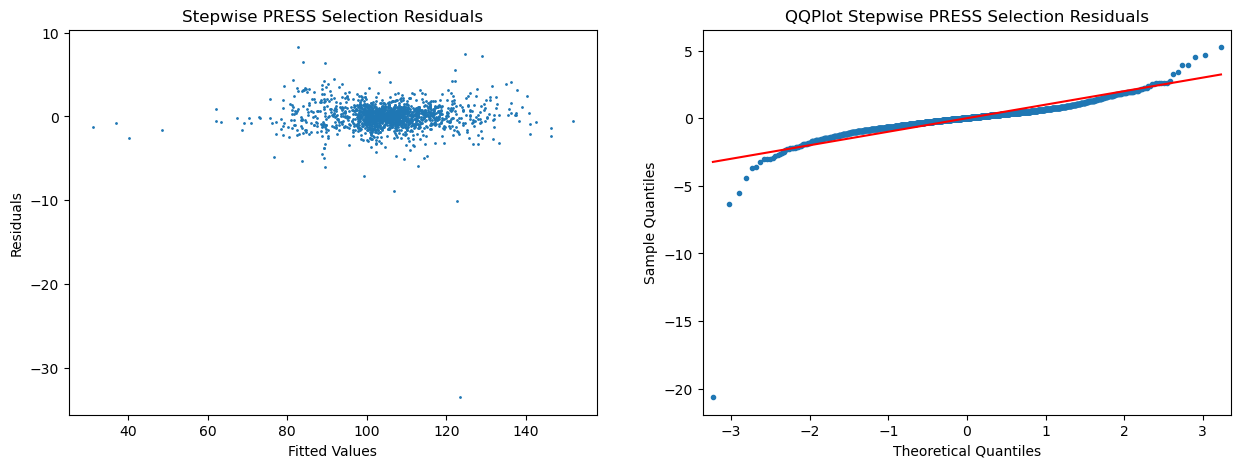

In [19]:
fig, ax = plt.subplots(1,2, figsize=[15,5])
ax[0].scatter(SW_PRESS_mod.fittedvalues, SW_PRESS_mod.resid, s = 1.0)
ax[0].set(xlabel='Fitted Values', ylabel='Residuals', title='Stepwise PRESS Selection Residuals')

sm.qqplot(SW_AIC_mod.resid, line='s', dist=spdists.norm, marker='.', ax=ax[1], fit=True)
ax[1].set(title = 'QQPlot Stepwise PRESS Selection Residuals')
plt.show()

Again, we see that the quality of the fit is unchanged.

The following code can help us see which variables are different between the two models:

In [20]:
s_AIC = set(features_chosen_AIC)
s_PRESS = set(features_chosen_PRESS)


AIC_PRESS = s_AIC - s_PRESS
PRESS_AIC = s_PRESS - s_AIC
AICnPRESS = s_AIC & s_PRESS
print(f'Variables in AIC not in PRESS: ({len(AIC_PRESS)} variables) \n {AIC_PRESS}\n')
print(f'Variables in PRESS not in AIC:({len(PRESS_AIC)} variables) \n {PRESS_AIC}\n')
print(f'Variables in both AIC and PRESS:({len(AICnPRESS)} variables) \n {AICnPRESS}')

Variables in AIC not in PRESS: (5 variables) 
 {'trade_price_last3', 'received_time_diff_last8_st', 'curve_based_price_last4', 'curve_based_price_last2', 'curve_based_price_last3'}

Variables in PRESS not in AIC:(3 variables) 
 {'received_time_diff_last7_st', 'reporting_delay', 'trade_type_last7_3'}

Variables in both AIC and PRESS:(19 variables) 
 {'is_callable_1', 'curve_based_price_last5', 'trade_price_last10', 'trade_type_last5_3', 'trade_type_last4_4', 'trade_price_last4', 'trade_size_lt', 'trade_type_3', 'received_time_diff_last10_st', 'trade_price_last7', 'trade_type_last4_3', 'trade_price_last9', 'trade_type_last1_4', 'trade_price_last1', 'trade_size_last1_lt', 'curve_based_price', 'trade_type_4', 'trade_type_last1_3', 'trade_size_last4_lt'}
